In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
import pandas as pd
from utils.deepmatcher_utils import wrapDm
import numpy as np

In [4]:
pd.set_option('display.max_colwidth',None)

In [5]:
selected_attributes = ['modelno','price','title','brand']
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../../models/walmartamazon_hybrid.pth')
model = model.to('cuda')

In [11]:
test_neg = pd.read_csv('../../datasets/Structured/Walmart-Amazon/test_negatives.csv')

In [12]:
test_neg['rtable_modelno'] = test_neg['ltable_modelno']
predictions = wrapDm(test_neg,model)
np.count_nonzero(np.argmax(predictions,axis=1)==1)

1769

In [9]:
negatives_nn = pd.read_csv('experiment_results/testneg_nn_hybrid_withfilter.csv')
positives = pd.read_csv('../../Structured/Walmart-Amazon/positives.csv')
critical_forNegatives = {}
for att in selected_attributes:
    criticalValues = generateExplanations(negatives_nn,positives,att,model,5,0.03
                                          ,'../../Structured/Walmart-Amazon/test_negatives.csv',0)
    critical_forNegatives[att] = criticalValues


Reading and processing data from "../../Structured/Walmart-Amazon/test_negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test0.csv"


Finished Epoch 17 || Run Time:    3.3 | Load Time:    1.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test1.csv"


Finished Epoch 17 || Run Time:    3.2 | Load Time:    1.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test2.csv"


Finished Epoch 17 || Run Time:    3.3 | Load Time:    1.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test3.csv"


Finished Epoch 17 || Run Time:    3.1 | Load Time:    1.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test4.csv"


Finished Epoch 17 || Run Time:    3.3 | Load Time:    1.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "../../Structured/Walmart-Amazon/test_negatives.csv"


Finished Epoch 17 || Run Time:    3.2 | Load Time:    1.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test0.csv"


Finished Epoch 17 || Run Time:    3.1 | Load Time:    1.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test1.csv"


Finished Epoch 17 || Run Time:    3.2 | Load Time:    1.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test2.csv"


Finished Epoch 17 || Run Time:    3.8 | Load Time:    1.5 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test3.csv"


Finished Epoch 17 || Run Time:    3.6 | Load Time:    1.5 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test4.csv"


Finished Epoch 17 || Run Time:    3.3 | Load Time:    1.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "../../Structured/Walmart-Amazon/test_negatives.csv"


Finished Epoch 17 || Run Time:    3.4 | Load Time:    1.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test0.csv"


Finished Epoch 17 || Run Time:    3.6 | Load Time:    1.5 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03

Reading and processing data from "temp/altered_test1.csv"


Finished Epoch 17 || Run Time:    3.0 | Load Time:    1.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test2.csv"


Finished Epoch 17 || Run Time:    3.1 | Load Time:    1.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03

Reading and processing data from "temp/altered_test3.csv"


Finished Epoch 17 || Run Time:    3.0 | Load Time:    1.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test4.csv"


Finished Epoch 17 || Run Time:    3.1 | Load Time:    1.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03

Reading and processing data from "../../Structured/Walmart-Amazon/test_negatives.csv"


Finished Epoch 17 || Run Time:    3.0 | Load Time:    1.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test0.csv"


Finished Epoch 17 || Run Time:    3.2 | Load Time:    1.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test1.csv"


Finished Epoch 17 || Run Time:    3.3 | Load Time:    1.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test2.csv"


Finished Epoch 17 || Run Time:    3.2 | Load Time:    1.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test3.csv"


Finished Epoch 17 || Run Time:    3.2 | Load Time:    1.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04

Reading and processing data from "temp/altered_test4.csv"


Finished Epoch 17 || Run Time:    3.1 | Load Time:    1.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


Finished Epoch 17 || Run Time:    3.2 | Load Time:    1.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



In [27]:
positives_nn = pd.read_csv('experiment_results/testpos_nn_hybrid_withfilter.csv')
negatives = pd.read_csv('../../Structured/Walmart-Amazon/negatives.csv')
critical_forPositives = {}
for att in selected_attributes:
    criticalValues = generateExplanations(positives_nn,negatives,att,model,5,0.03
                                          ,'../../Structured/Walmart-Amazon/test_positives.csv',1)
    critical_forPositives[att] = criticalValues


Reading and processing data from "../../Structured/Walmart-Amazon/test_positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test0.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test1.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test2.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test3.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test4.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "../../Structured/Walmart-Amazon/test_positives.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test0.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test1.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test2.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test3.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test4.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "../../Structured/Walmart-Amazon/test_positives.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test0.csv"


Finished Epoch 17 || Run Time:    0.5 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test1.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test2.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test3.csv"


Finished Epoch 17 || Run Time:    0.5 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test4.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "../../Structured/Walmart-Amazon/test_positives.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test0.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test1.csv"


Finished Epoch 17 || Run Time:    0.5 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test2.csv"


Finished Epoch 17 || Run Time:    0.5 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test3.csv"


Finished Epoch 17 || Run Time:    0.5 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Reading and processing data from "temp/altered_test4.csv"


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 17 || Run Time:    0.4 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



In [34]:
len(critical_forPositives['title'])

4

In [36]:
critical_forPositives['title'][1]

,match_score,label,ltable_title,ltable_category,ltable_brand,ltable_modelno,ltable_price,rtable_title,rtable_category,rtable_brand,rtable_modelno,rtable_price
id,,,,,,,,,,,,
9418,0.347503,1,epson t060320 ink cartridge magenta,stationery & office machinery,balt,33250,239.88,epson t032120 twin pack black ink cartridge 2 ...,laminating supplies,mayline,NaN,134.45
8603,0.365050,1,epson t060320 ink cartridge magenta,tv accessories,srs labs,dct6s,59.99,epson t032120 twin pack black ink cartridge 2 ...,accessories,srs,NaN,65.00
9604,0.325227,1,epson t060320 ink cartridge magenta,stationery & office machinery,paper mate,1739312,4.87,epson t032120 twin pack black ink cartridge 2 ...,printer accessories,paper mate,NaN,23.96
8786,0.363413,1,epson t060320 ink cartridge magenta,stationery & office machinery,lexmark,1382920,270.90,epson t032120 twin pack black ink cartridge 2 ...,computer accessories,lexmark,NaN,574.19
8415,0.340841,1,epson t060320 ink cartridge magenta,electronics - general,da-lite,87184,167.99,epson t032120 twin pack black ink cartridge 2 ...,projection screens,da-lite,NaN,NaN
10271,0.354666,1,epson t060320 ink cartridge magenta,digital cameras,canon,5035b001aa,156.54,epson t032120 twin pack black ink cartridge 2 ...,point shoot digital cameras,canon,5035b001,159.00
9164,0.353868,1,epson t060320 ink cartridge magenta,usb drives,wintec,3fmcf4gb-r,15.98,epson t032120 twin pack black ink cartridge 2 ...,memory cards,wintec,3fmcf32gbs-r,79.99
9543,0.333047,1,epson t060320 ink cartridge magenta,electronics - general,da-lite,84992,2735.99,epson t032120 twin pack black ink cartridge 2 ...,projection screens,da-lite,cosmopolitan electrol,NaN
10131,0.323298,1,epson t060320 ink cartridge magenta,prepaid wireless phones,t-mobile,t249,49.84,epson t032120 twin pack black ink cartridge 2 ...,no-contract phones,samsung,t239,59.99


## Black-box explanation

In [5]:
from utils.triangles_method import explainSamples

In [6]:
DATA_DIR ='../../datasets/Structured/Walmart-Amazon/'
allSamples = pd.read_csv(DATA_DIR+'complete_dataset.csv')

In [7]:
hybrid = dm.MatchingModel(attr_summarizer='hybrid')
hybrid.load_state('../../models/walmartamazon_hybrid.pth')
hybrid = hybrid.to('cuda')

In [7]:
rnn = dm.MatchingModel(attr_summarizer='rnn')
rnn.load_state('../../models/walmartamazon_rnn.pth')
rnn = rnn.to('cuda')

In [10]:
prediction = wrapDm(allSamples,rnn,ignore_columns=['label'])
correct_preds = allSamples[np.argmax(prediction,axis=1)==allSamples.label.values]
len(allSamples),len(correct_preds)

(10242, 9962)

In [8]:
prediction4hybrid = wrapDm(allSamples,hybrid,ignore_columns=['label'])
correct_preds4hybrid = allSamples[np.argmax(prediction4hybrid,axis=1)==allSamples.label.values]
len(allSamples),len(correct_preds4hybrid)

(10242, 9961)

In [10]:
walmart = pd.read_csv(DATA_DIR+'tableA.csv',dtype=str)
amazon = pd.read_csv(DATA_DIR+'tableB.csv',dtype=str)

In [20]:
neg_ranking,flippedneg = explainSamples(correct_preds,[walmart,amazon],rnn,predict_fn,
                                       class_to_explain=0,maxLenAttributeSet=1)

100%|██████████| 4290/4290 [21:38<00:00,  3.30it/s]


In [11]:
neg_ranking4hybrid,flippedneg4hybrid = explainSamples(correct_preds4hybrid,[walmart,amazon],hybrid,wrapDm,
                                       class_to_explain=0,maxLenAttributeSet=1)

  2%|▏         | 107/4346 [01:35<1:03:51,  1.11it/s]

KeyboardInterrupt: 

In [13]:
pos_ranking,flippedpos = explainSamples(correct_preds,[walmart,amazon],rnn,predict_fn,
                                       class_to_explain=1,maxLenAttributeSet=1)

100%|██████████| 4290/4290 [21:21<00:00,  3.35it/s]


In [22]:
flippedneg.to_csv('rnn_flippedneg.csv',index=False)

In [14]:
flippedpos.to_csv('rnn_flippedpos.csv',index=False)

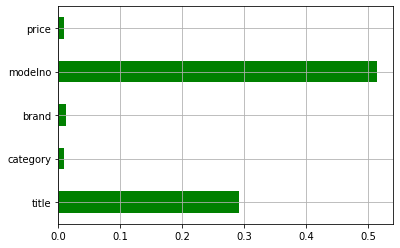

In [16]:
pos_ranking.plot.barh(color='green',grid=True).get_figure().savefig('rnn_pos_ranking.png')

## Patterns extraction

In [5]:
import ast
from utils.patternDiscovery import getMaxFrequentPatterns

In [23]:
flippedneg = pd.read_csv('rnn_flippedneg.csv')
flippedpos = pd.read_csv('rnn_flippedpos.csv')

In [24]:
flippedneg['alteredAttributes'] = flippedneg['alteredAttributes'].apply(lambda t:ast.literal_eval(t))
flippedpos['alteredAttributes'] = flippedpos['alteredAttributes'].apply(lambda t:ast.literal_eval(t))

In [36]:
neg_pattern_on_title = getMaxFrequentPatterns(flippedpos[flippedpos.alteredAttributes==('title',)],
                                             ['ltable_title','rtable_title'])

In [44]:
neg_pattern_on_title.head(10)

,support,itemsets
0,0.201754,"(L_rear, R_x, R_projection, L_screen, R_screen, L_x, L_projection, R_rear, R_format, L_format)"
1,0.205742,(L_video)
2,0.212919,"(R_-, R_x, L_screen, R_screen, L_x, R_format, L_format)"
3,0.242424,(L_black)
4,0.200159,"(R_-, L_-, R_x)"
5,0.210526,"(L_x, L_-, R_x)"


In [49]:
pos_pattern_on_title = getMaxFrequentPatterns(flippedneg[flippedneg.alteredAttributes==('title',)],
                                             ['ltable_title','rtable_title'])
pos_pattern_on_title.head(10)

,support,itemsets
0,0.202142,(L_screen)
1,0.220884,"(L_x, R_x)"
2,0.224900,(L_black)
3,0.433735,(L_-)


In [43]:
flippedpos[flippedpos.alteredAttributes==('title',)].sample(n=10)

,ltable_title,ltable_category,ltable_brand,ltable_modelno,ltable_price,rtable_title,rtable_category,rtable_brand,rtable_modelno,rtable_price,alteredAttributes
1439,bower ss2477g digital camera wrist strap 1.50-inch - grey,binocular accessories,bower,ss2477g,5.99,bower ss26 digital neck strap green,camera and camcorder accessories,bower,relaunch ss2477g,7.98,"(title,)"
855,kodak easyshare m531 14mp hd digital camera w 3x optical 5x digital zoom 2.7 bright lcd screen red black 4gb sd card,point shoot digital camera bundles,kodak,m531,NaN,kodak easyshare m550 12 mp digital camera with 5x wide angle optical zoom and 2.7-inch lcd purple,digital cameras,kodak,m531 red,89.00,"(title,)"
2314,da-lite da-plex base rear projection screen - 57 3 4 x 77 video format,electronics - general,da-lite,27528,2608.99,da-lite da-plex deluxe rear projection screen - 58 x 104 hdtv format,projection screens,da-lite,NaN,2608.99,"(title,)"
1136,los angeles lakers ipod touch 4g hard case,computers accessories,tribeca,NaN,29.99,pittsburgh penguins ipod touch 4g hard case,electronics - general,tribeca,fva4614,29.99,"(title,)"
1477,chicago bears ipod touch 4g hard case,computers accessories,tribeca,NaN,29.99,dallas cowboys ipod touch 4g hard case,electronics - general,tribeca,fva4587,29.99,"(title,)"
419,x651h11a high-yield toner 25000 page-yield black,inkjet printer ink,lexmark,NaN,413.69,e260a21a toner 3500 page-yield black,printers,lexmark,x651h11a,565.20,"(title,)"
3106,da-lite honey maple veneer model b manual screen with matte white fabric - 60 x 60 diagonal video format,electronics - general,da-lite,87184,167.99,da-lite light oak veneer model b manual screen with high power fabric - 60 x 60 av format,projection screens,da-lite,NaN,NaN,"(title,)"
2179,smead 75174 - 5 1 4 inch expansion end tab file pockets with tyvek letter manila 10 box,NaN,smead,NaN,NaN,smead 10300 - file folders straight cut one-ply top tab letter manila 100 box,stationery & office machinery,NaN,75174,37.94,"(title,)"
2576,kodak m552 dark pink 14mp digital camera bundle w 5x optical zoom 2.7 lcd display w 50 bonus prints,digital cameras,kodak,m552 pink bndl,109.00,kodak easyshare m530 red 12mp digital camera w 3x optical zoom 2.7 lcd w 50 bonus prints,point shoot digital cameras,kodak,1942390,NaN,"(title,)"
937,i-tec t6020 ipad r anti-glare screen protector,printers,i-tec,NaN,NaN,antiglare screen protector evo 4g,mp3 accessories,i-tec electronics,t6020,17.88,"(title,)"


## Test pattern influence

In [12]:
test_df = pd.read_csv(DATA_DIR+'merged_test.csv')
positives = test_df[test_df.label==1].copy()
len(positives)

193

In [18]:
predictions = wrapDm(positives,rnn,['label'])
np.count_nonzero(np.argmax(predictions,axis=1)==0)

50

In [19]:
positives = test_df[test_df.label==1].copy()
positives['ltable_title'] =  " rear projection screen x format "+ positives['ltable_title']
positives['rtable_title'] =  " rear projection screen x format "+ positives['rtable_title']

In [20]:
predictions = wrapDm(positives,rnn,['label'])
np.count_nonzero(np.argmax(predictions,axis=1)==0)

50